<a href="https://colab.research.google.com/github/ishita966/Ultrahack/blob/master/color_the_xray_all_cases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sklearn
import sklearn.metrics as sklm
from __future__ import print_function, division

# pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# image imports
from skimage import io, transform
from PIL import Image

# general imports
import os
import time
from shutil import copyfile
from shutil import rmtree

# data science imports
import pandas as pd
import numpy as np
import csv



# image / graphics imports
from pylab import *
import seaborn as sns
from matplotlib.pyplot import show 


import scipy as sp

# import other modules
from copy import deepcopy   #doesnt stores the reference. stores the copy.

In [0]:
class CXRDataset(Dataset):

    def __init__(
            self,
            path_to_images,
            fold,
            transform=None,
            sample=0,
            finding="any",
            starter_images=False):

        self.transform = transform
        self.path_to_images = path_to_images
        self.df = pd.read_csv("final_labels.csv")
        self.df = self.df[self.df['fold'] == fold]

        if(starter_images):
            starter_images = pd.read_csv("starter_images.csv")
            self.df=pd.merge(left=self.df,right=starter_images, how="inner",on="Image_index")
            
        # can limit to sample, useful for testing
        # if fold == "train" or fold =="val": sample=500
        if(sample > 0 and sample < len(self.df)):
            self.df = self.df.sample(sample)

        if not finding == "any":  # can filter for positive findings of the kind described; useful for evaluation
            if finding in self.df.columns:
                if len(self.df[self.df[finding] == 1]) > 0:
                    self.df = self.df[self.df[finding] == 1]
                else:
                    print("No positive cases exist for "+LABEL+", returning all unfiltered cases")
            else:
                print("cannot filter on finding " + finding +
                      " as not in data - please check spelling")

        self.df = self.df.set_index("Image_index")
        self.PRED_LABEL = [
            'Atelectasis',
            'Cardiomegaly',
            'Effusion',
            'Infiltration',
            'Mass',
            'Nodule',
            'Pneumonia',
            'Pneumothorax',
            'Consolidation',
            'Edema',
            'Emphysema',
            'Fibrosis',
            'Pleural_Thickening',
            'Hernia']
        RESULT_PATH = "C:/Users/Ishita Jain/Desktop/results"

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        image = Image.open(
            os.path.join(
                self.path_to_images,
                self.df.index[idx]))
        image = image.convert('RGB')

        label = np.zeros(len(self.PRED_LABEL), dtype=int)
        for i in range(0, len(self.PRED_LABEL)):
             # can leave zero if zero, else make one
            if(self.df[self.PRED_LABEL[i].strip()].iloc[idx].astype('int') > 0):
                label[i] = self.df[self.PRED_LABEL[i].strip()
                                   ].iloc[idx].astype('int')

        if self.transform:
            image = self.transform(image)

        return (image, label,self.df.index[idx])

In [0]:
def make_pred_multilabel(data_transforms, model, PATH_TO_IMAGES):
    """
    Gives predictions for test fold and calculates AUCs using previously trained model

    Args:
        data_transforms: torchvision transforms to preprocess raw images; same as validation transforms
        model: densenet-121 from torchvision previously fine tuned to training data
        PATH_TO_IMAGES: path at which NIH images can be found
    Returns:
        pred_df: dataframe containing individual predictions and ground truth for each test image
        auc_df: dataframe containing aggregate AUCs by train/test tuples
    """

    # calc preds in batches of 16, can reduce if your GPU has less RAM
    BATCH_SIZE = 6

    # set model to eval mode; required for proper predictions given use of batchnorm
    model.train(False)

    # create dataloader
    dataset = CXRDataset(
        path_to_images=PATH_TO_IMAGES,
        fold="test",
        transform=data_transforms['val'])
    dataloader = torch.utils.data.DataLoader(
        dataset, BATCH_SIZE, shuffle=False, num_workers=8)
    size = len(dataset)

    # create empty dfs
    pred_df = pd.DataFrame(columns=["Image_index"])
    true_df = pd.DataFrame(columns=["Image_index"])

    # iterate over dataloader
    for i, data in enumerate(dataloader):

        inputs, labels, _ = data
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        true_labels = labels.cpu().data.numpy()
        batch_size = true_labels.shape

        outputs = model(inputs)
        probs = outputs.cpu().data.numpy()

        # get predictions and true values for each item in batch
        for j in range(0, batch_size[0]):
            thisrow = {}
            truerow = {}
            thisrow["Image_index"] = dataset.df.index[BATCH_SIZE * i + j]
            truerow["Image_index"] = dataset.df.index[BATCH_SIZE * i + j]

            # iterate over each entry in prediction vector; each corresponds to
            # individual label
            for k in range(len(dataset.PRED_LABEL)):
                thisrow["prob_" + dataset.PRED_LABEL[k]] = probs[j, k]
                truerow[dataset.PRED_LABEL[k]] = true_labels[j, k]

            pred_df = pred_df.append(thisrow, ignore_index=True)
            true_df = true_df.append(truerow, ignore_index=True)

        if(i % 10 == 0):
            print(str(i * BATCH_SIZE))

    auc_df = pd.DataFrame(columns=["label", "auc"])

    # calc AUCs
    for column in true_df:

        if column not in [
            'Atelectasis',
            'Cardiomegaly',
            'Effusion',
            'Infiltration',
            'Mass',
            'Nodule',
            'Pneumonia',
            'Pneumothorax',
            'Consolidation',
            'Edema',
            'Emphysema',
            'Fibrosis',
            'Pleural_Thickening',
                'Hernia']:
                    continue
        actual = true_df[column]
        pred = pred_df["prob_" + column]
        thisrow = {}
        thisrow['label'] = column
        thisrow['auc'] = np.nan
        try:
            thisrow['auc'] = sklm.roc_auc_score(
                actual.as_matrix().astype(int), pred.as_matrix())
        except BaseException:
            print("can't calculate auc for " + str(column))
        auc_df = auc_df.append(thisrow, ignore_index=True)

    pred_df.to_csv("results/preds.csv", index=False)
    auc_df.to_csv("results/aucs.csv", index=False)
    return pred_df, auc_df

In [20]:
use_gpu = torch.cuda.is_available()
gpu_count = torch.cuda.device_count()
print("Available GPU count:" + str(gpu_count))

Available GPU count:1


In [0]:
def checkpoint(model, best_loss, epoch, LR):
    """
    Saves checkpoint of torchvision model during training.

    Args:
        model: torchvision model to be saved
        best_loss: best val loss achieved so far in training
        epoch: current epoch of training
        LR: current learning rate in training
    Returns:
        None
    """

    print('saving')
    state = {
        'model': model,
        'best_loss': best_loss,
        'epoch': epoch,
        'rng_state': torch.get_rng_state(),
        'LR': LR
    }

    torch.save(state, 'results/checkpoint')


def train_model(
        model,
        criterion,
        optimizer,
        LR,
        num_epochs,
        dataloaders,
        dataset_sizes,
        weight_decay):
    """
    Fine tunes torchvision model to NIH CXR data.

    Args:
        model: torchvision model to be finetuned (densenet-121 in this case)
        criterion: loss criterion (binary cross entropy loss, BCELoss)
        optimizer: optimizer to use in training (SGD)
        LR: learning rate
        num_epochs: continue training up to this many epochs
        dataloaders: pytorch train and val dataloaders
        dataset_sizes: length of train and val datasets
        weight_decay: weight decay parameter we use in SGD with momentum
    Returns:
        model: trained torchvision model
        best_epoch: epoch on which best model val loss was obtained

    """
    print("in train model")
    since = time.time()

    start_epoch = 1
    best_loss = 999999
    best_epoch = -1
    last_train_loss = -1

    # iterate over epochs
    for epoch in range(start_epoch, num_epochs + 1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # set model to train or eval mode based on whether we are in train or
        # val; necessary to get correct predictions given batchnorm
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0

            i = 0
            total_done = 0
            # iterate over all data in train/val dataloader:
            for data in dataloaders[phase]:
                print("data[0] is : ")
                print(data[0])
                print("data[0] printed")
                i += 1
                inputs, labels, _ = data
                batch_size = inputs.shape[0]
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda()).float()
                outputs = model(inputs)

                # calculate gradient and update parameters in train phase
                optimizer.zero_grad()
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss +=(loss.data) * batch_size

            epoch_loss = running_loss / dataset_sizes[phase]

            if phase == 'train':
                last_train_loss = epoch_loss

            print(phase + ' epoch {}:loss {:.4f} with data size {}'.format(
                epoch, epoch_loss, dataset_sizes[phase]))

            # decay learning rate if no val loss improvement in this epoch

            if phase == 'val' and epoch_loss > best_loss:
                print("decay loss from " + str(LR) + " to " +
                      str(LR / 10) + " as not seeing improvement in val loss")
                LR = LR / 10
                # create new optimizer with lower learning rate
                optimizer = optim.SGD(
                    filter(
                        lambda p: p.requires_grad,
                        model.parameters()),
                    lr=LR,
                    momentum=0.9,
                    weight_decay=weight_decay)
                print("created new optimizer with LR " + str(LR))

            # checkpoint model if has best val loss yet
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_epoch = epoch
                checkpoint(model, best_loss, epoch, LR)

            # log training and validation loss over each epoch
            if phase == 'val':
                with open("results/log_train", 'a') as logfile:
                    logwriter = csv.writer(logfile, delimiter=',')
                    if(epoch == 1):
                        logwriter.writerow(["epoch", "train_loss", "val_loss"])
                    logwriter.writerow([epoch, last_train_loss, epoch_loss])

        total_done += batch_size
        if(total_done % (100 * batch_size) == 0):
            print("completed " + str(total_done) + " so far in epoch")

        # break if no val loss improvement in 3 epochs
        if ((epoch - best_epoch) >= 3):
            print("no improvement in 3 epochs, break")
            break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # load best model weights to return
    checkpoint_best = torch.load('results/checkpoint')
    model = checkpoint_best['model']

    return model, best_epoch


def train_cnn(PATH_TO_IMAGES, LR, WEIGHT_DECAY):
    """
    Train torchvision model to NIH data given high level hyperparameters.

    Args:
        PATH_TO_IMAGES: path to NIH images
        LR: learning rate
        WEIGHT_DECAY: weight decay parameter for SGD

    Returns:
        preds: torchvision model predictions on test fold with ground truth for comparison
        aucs: AUCs for each train,test tuple

    """
    print("in train_cnn")
    NUM_EPOCHS = 5
    BATCH_SIZE = 2

    try:
        rmtree('results/')
    except BaseException:
        pass  # directory doesn't yet exist, no need to clear it
    os.makedirs("results/")

    # use imagenet mean,std for normalization
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    N_LABELS = 14  # we are predicting 14 labels

    # load labels
    df = pd.read_csv("final_labels.csv", index_col=0)
    
    # define torchvision transforms
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.Resize(224),
            # because scale doesn't always give 224 x 224, this ensures 224 x
            # 224
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
        'val': transforms.Compose([
            transforms.Scale(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
    }

    # create train/val dataloaders
    transformed_datasets = {}
    transformed_datasets['train'] = CXRDataset(
        path_to_images=PATH_TO_IMAGES,
        fold='train',
        transform=data_transforms['train'])
    transformed_datasets['val'] = CXRDataset(
        path_to_images=PATH_TO_IMAGES,
        fold='val',
        transform=data_transforms['val'])
    print("transformed dataset")
    print( transformed_datasets['train'])
    
    dataloaders = {}
    dataloaders['train'] = torch.utils.data.DataLoader(
        transformed_datasets['train'],
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=8)
    dataloaders['val'] = torch.utils.data.DataLoader(
        transformed_datasets['val'],
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=8)
    print("dataloaders")
    print(dataloaders['train'])

    # please do not attempt to train without GPU as will take excessively long
    if not use_gpu:
        print("no gpu? why?")
        raise ValueError("Error, requires GPU")
    model = models.densenet121(pretrained=True)
    num_ftrs = model.classifier.in_features
    # add final layer with # outputs in same dimension of labels with sigmoid
    # activation
    model.classifier = nn.Sequential(
        nn.Linear(num_ftrs, N_LABELS), nn.Sigmoid())

    # put model on GPU
    print("MODEL PUT ON GPU")
    model = model.cuda()

    # define criterion, optimizer for training
    criterion = nn.BCELoss()
    optimizer = optim.SGD(
        filter(
            lambda p: p.requires_grad,
            model.parameters()),
        lr=LR,
        momentum=0.9,
        weight_decay=WEIGHT_DECAY)
    dataset_sizes = {x: len(transformed_datasets[x]) for x in ['train', 'val']}
    print("dataset_sizes:")
    print(dataset_sizes)
    print("training model")
    # train model
    model, best_epoch = train_model(model, criterion, optimizer, LR, num_epochs=NUM_EPOCHS,
                                    dataloaders=dataloaders, dataset_sizes=dataset_sizes, weight_decay=WEIGHT_DECAY)

    # get preds and AUCs on test fold
    print("model and best epoch returned")
    preds, aucs = make_pred_multilabel(
        data_transforms, model, PATH_TO_IMAGES)

    return preds, aucs

In [22]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving final_images.zip to final_images.zip
User uploaded file "final_images.zip" with length 44871373 bytes


In [0]:
import zipfile
import io
data = zipfile.ZipFile(io.BytesIO(uploaded['final_images.zip']), 'r')
data.extractall()

In [24]:
data.printdir()

File Name                                             Modified             Size
final_images/00000001_000.png                  2019-04-11 17:07:32       457171
final_images/00000001_001.png                  2019-04-11 17:07:32       444655
final_images/00000001_002.png                  2019-04-11 17:07:32       351772
final_images/00000002_000.png                  2019-04-11 17:07:32       402332
final_images/00000003_000.png                  2019-04-11 17:07:32       450000
final_images/00000003_001.png                  2019-04-11 17:07:32       383773
final_images/00000003_002.png                  2019-04-11 17:07:32       343273
final_images/00000003_003.png                  2019-04-11 17:07:34       456605
final_images/00000003_004.png                  2019-04-11 17:07:34       371185
final_images/00000003_005.png                  2019-04-11 17:07:34       437334
final_images/00000003_006.png                  2019-04-11 17:07:34       413626
final_images/00000003_007.png           

In [25]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving final_labels.csv to final_labels.csv
User uploaded file "final_labels.csv" with length 7459 bytes


In [0]:
def calc_cam(x, label, model):
    """
    function to generate a class activation map corresponding to a torch image tensor

    Args:
        x: the 1x3x224x224 pytorch tensor file that represents the NIH CXR
        label:user-supplied label you wish to get class activation map for; must be in FINDINGS list
        model: densenet121 trained on NIH CXR data

    Returns:
        cam_torch: 224x224 torch tensor containing activation map
    """
    FINDINGS = [
        'Atelectasis',
        'Cardiomegaly',
        'Effusion',
        'Infiltration',
        'Mass',
        'Nodule',
        'Pneumonia',
        'Pneumothorax',
        'Consolidation',
        'Edema',
        'Emphysema',
        'Fibrosis',
        'Pleural_Thickening',
        'Hernia']

    if label not in FINDINGS:
        raise ValueError(
            str(label) +
            "is an invalid finding - please use one of " +
            str(FINDINGS))

    # find index for label; this corresponds to index from output of net
    label_index = next(
        (x for x in range(len(FINDINGS)) if FINDINGS[x] == label))

    # define densenet_last_layer class so we can get last 1024 x 7 x 7 output
    # of densenet for class activation map
    class densenet_last_layer(torch.nn.Module):
        def __init__(self, model):
            super(densenet_last_layer, self).__init__()
            self.features = torch.nn.Sequential(
                *list(model.children())[:-1]
            )

        def forward(self, x):
            x = self.features(x)
            x = torch.nn.functional.relu(x, inplace=True)
            return x

    # instantiate cam model and get output
    model_cam = densenet_last_layer(model)
    x = torch.autograd.Variable(x)
    y = model_cam(x)
    y = y.cpu().data.numpy()
    y = np.squeeze(y)

    # pull weights corresponding to the 1024 layers from model
    weights = model.state_dict()['classifier.0.weight']
    weights = weights.cpu().numpy()
    
    bias = model.state_dict()['classifier.0.bias']
    bias = bias.cpu().numpy()
    
    # can replicate bottleneck and probability calculation here from last_layer network and params from
    # original network to ensure that reconstruction is accurate -- commented out as previously checked
    
    #model_bn = deepcopy(model)
    #new_classifier = torch.nn.Sequential(*list(model_bn.classifier.children())[:-2])
    #model_bn.classifier = new_classifier
    #bn=model_bn(x)
    #recreate=0
    #bottleneck = []
    #for k in range(0,1024):
    #    avg_value = np.mean(y[k,:,:])# over the 7x7 grid
    #    bottleneck.append(avg_value)
    #    recreate = recreate+weights[label_index,k]*avg_value
    #recreate = recreate + bias[label_index]
    #recreate = 1/(1+math.exp(-recreate))
    #print("recalc:")
    #print(recreate)
    #print("original:")
    #print(model(x).data.numpy()[0][label_index])

    # create 7x7 cam
    cam = np.zeros((7, 7, 1))
    for i in range(0, 7):
        for j in range(0, 7):
            for k in range(0, 1024):
                cam[i, j] += y[k, i, j] * weights[label_index, k]
    cam+=bias[label_index]

    #make cam into local region probabilities with sigmoid
    
    cam=1/(1+np.exp(-cam))
    
    label_baseline_probs={
        'Atelectasis':0.103,
        'Cardiomegaly':0.025,
        'Effusion':0.119,
        'Infiltration':0.177,
        'Mass':0.051,
        'Nodule':0.056,
        'Pneumonia':0.012,
        'Pneumothorax':0.047,
        'Consolidation':0.042,
        'Edema':0.021,
        'Emphysema':0.022,
        'Fibrosis':0.015,
        'Pleural_Thickening':0.03,
        'Hernia':0.002
    }
    
    #normalize by baseline probabilities
    cam = cam/label_baseline_probs[label]
    
    #take log
    cam = np.log(cam)
    
    return cam

def load_data(
        PATH_TO_IMAGES,
        LABEL,
        PATH_TO_MODEL,
        POSITIVE_FINDINGS_ONLY,
        STARTER_IMAGES):
    """
    Loads dataloader and torchvision model

    Args:
        PATH_TO_IMAGES: path to NIH CXR images
        LABEL: finding of interest (must exactly match one of FINDINGS defined below or will get error)
        PATH_TO_MODEL: path to downloaded pretrained model or your own retrained model
        POSITIVE_FINDINGS_ONLY: dataloader will show only examples + for LABEL pathology if True, otherwise shows positive
                                and negative examples if false

    Returns:
        dataloader: dataloader with test examples to show
        model: fine tuned torchvision densenet-121
    """

    checkpoint = torch.load(PATH_TO_MODEL, map_location=lambda storage, loc: storage)
    model = checkpoint['model']
    del checkpoint
    model.cpu()

    # build dataloader on test
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    FINDINGS = [
        'Atelectasis',
        'Cardiomegaly',
        'Effusion',
        'Infiltration',
        'Mass',
        'Nodule',
        'Pneumonia',
        'Pneumothorax',
        'Consolidation',
        'Edema',
        'Emphysema',
        'Fibrosis',
        'Pleural_Thickening',
        'Hernia']

    data_transform = transforms.Compose([
        transforms.Scale(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    if not POSITIVE_FINDINGS_ONLY:
        finding = "any"
    else:
        finding = LABEL

    dataset = CXRDataset(
        path_to_images=PATH_TO_IMAGES,
        fold='test',
        transform=data_transform,
        finding=finding,
        starter_images=STARTER_IMAGES)
    
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=1, shuffle=False, num_workers=1)
    
    return iter(dataloader), model


def show_next(dataloader, model, LABEL):
    """
    Plots CXR, activation map of CXR, and shows model probabilities of findings

    Args:
        dataloader: dataloader of test CXRs
        model: fine-tuned torchvision densenet-121
        LABEL: finding we're interested in seeing heatmap for
    Returns:
        None (plots output)
    """
    FINDINGS = [
        'Atelectasis',
        'Cardiomegaly',
        'Effusion',
        'Infiltration',
        'Mass',
        'Nodule',
        'Pneumonia',
        'Pneumothorax',
        'Consolidation',
        'Edema',
        'Emphysema',
        'Fibrosis',
        'Pleural_Thickening',
        'Hernia']
    
    label_index = next(
        (x for x in range(len(FINDINGS)) if FINDINGS[x] == LABEL))

    # get next iter from dataloader
    try:
        inputs, labels, filename = next(dataloader)
    except StopIteration:
        print("All examples exhausted - rerun cells above to generate new examples to review")
        return None
        
    # get cam map
    original = inputs.clone()
    raw_cam = calc_cam(inputs, LABEL, model)
    
    # create predictions for label of interest and all labels
    pred = model(torch.autograd.Variable(original.cpu())).data.numpy()[0]
    predx = ['%.3f' % elem for elem in list(pred)]
    
    fig, (showcxr,heatmap) =plt.subplots(ncols=2,figsize=(14,5))
    
    hmap = sns.heatmap(raw_cam.squeeze(),
            cmap = 'viridis',
            alpha = 0.3, # whole heatmap is translucent
            annot = True,
            zorder = 2,square=True,vmin=-5,vmax=5
            )
    
    cxr=inputs.numpy().squeeze().transpose(1,2,0)    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    cxr = std * cxr + mean
    cxr = np.clip(cxr, 0, 1)
        
    hmap.imshow(cxr,
          aspect = hmap.get_aspect(),
          extent = hmap.get_xlim() + hmap.get_ylim(),
          zorder = 1) #put the map under the heatmap
    hmap.axis('off')
    hmap.set_title("P("+LABEL+")="+str(predx[label_index]))
    
    showcxr.imshow(cxr)
    showcxr.axis('off')
    showcxr.set_title(filename[0])
    plt.savefig(str(LABEL+"_P"+str(predx[label_index])+"_file_"+filename[0]))
    plt.show()
    
    
        
    preds_concat=pd.concat([pd.Series(FINDINGS),pd.Series(predx),pd.Series(labels.numpy().astype(bool)[0])],axis=1)
    preds = pd.DataFrame(data=preds_concat)
    preds.columns=["Finding","Predicted Probability","Ground Truth"]
    preds.set_index("Finding",inplace=True)
    preds.sort_values(by='Predicted Probability',inplace=True,ascending=False)
    
    return preds

In [27]:
PATH_TO_IMAGES = "final_images"
WEIGHT_DECAY = 1e-4
LEARNING_RATE = 0.9
preds, aucs = train_cnn(PATH_TO_IMAGES, LEARNING_RATE, WEIGHT_DECAY)

in train_cnn
transformed dataset
dataloaders


/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:208: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.torch/models/densenet121-a639ec97.pth
32342954it [00:00, 40877262.11it/s]


MODEL PUT ON GPU
dataset_sizes:
{'train': 94, 'val': 2}
training model
in train model
Epoch 1/5
----------
data[0] is : 
tensor([[[[-1.9638, -1.9467, -1.9124,  ..., -2.0494, -2.0837, -2.0837],
          [-1.8268, -1.7583, -1.7240,  ..., -2.0152, -2.0494, -2.0837],
          [-1.7240, -1.5870, -1.4500,  ..., -1.9809, -1.9980, -2.0152],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-1.8782, -1.8606, -1.8256,  ..., -1.9657, -2.0007, -2.0007],
          [-1.7381, -1.6681, -1.6331,  ..., -1.9307, -1.9657, -2.0007],
          [-1.6331, -1.4930, -1.3529,  ..., -1.8957, -1.9132, -1.9307],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92:

can't calculate auc for Atelectasis
can't calculate auc for Cardiomegaly
can't calculate auc for Consolidation
can't calculate auc for Edema
can't calculate auc for Emphysema
can't calculate auc for Hernia
can't calculate auc for Pneumonia
can't calculate auc for Pneumothorax


In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
STARTER_IMAGES=False
PATH_TO_IMAGES = "final_images"

In [0]:
PATH_TO_MODEL = "results/checkpoint"

In [0]:
LABEL="Pneumonia"

In [0]:
POSITIVE_FINDINGS_ONLY=True

In [39]:
dataloader,model= load_data(PATH_TO_IMAGES,LABEL,PATH_TO_MODEL,POSITIVE_FINDINGS_ONLY,STARTER_IMAGES)
print("Cases for review:")
print(len(dataloader))

No positive cases exist for Pneumonia, returning all unfiltered cases
Cases for review:
12


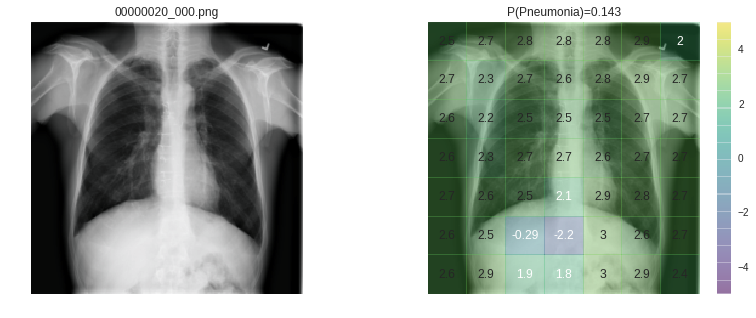

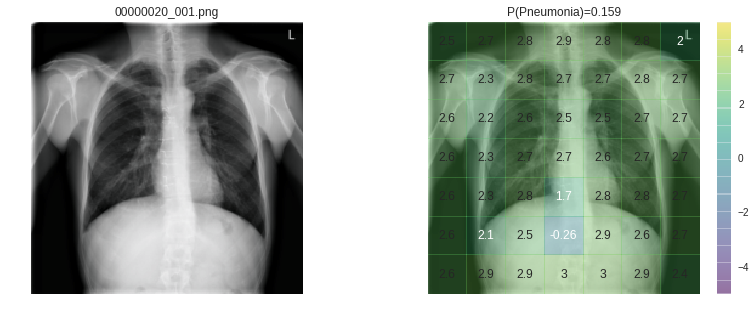

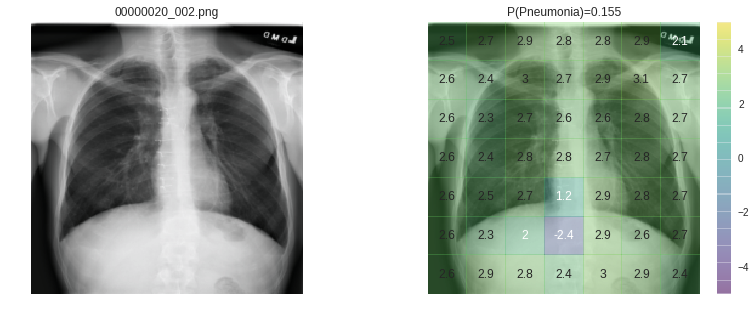

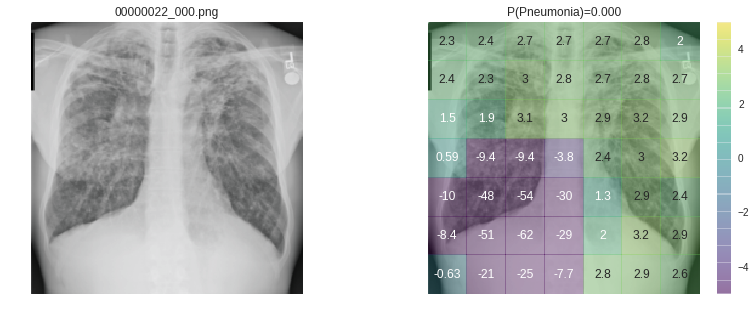

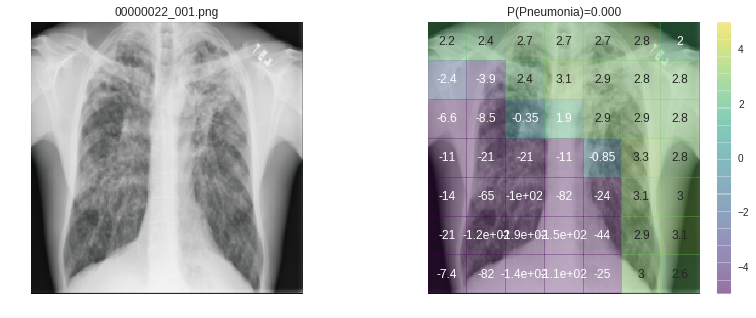

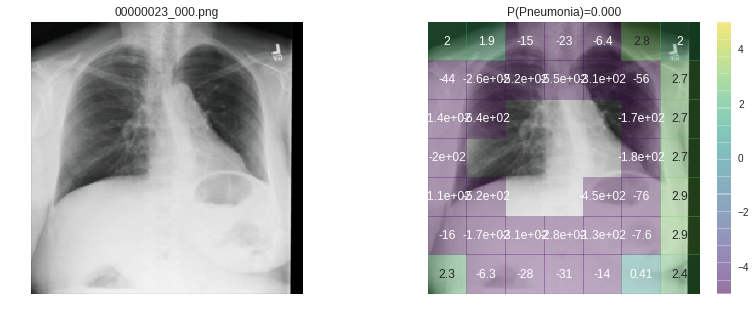

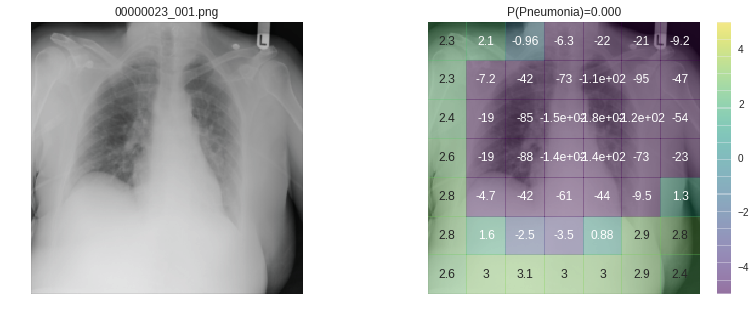

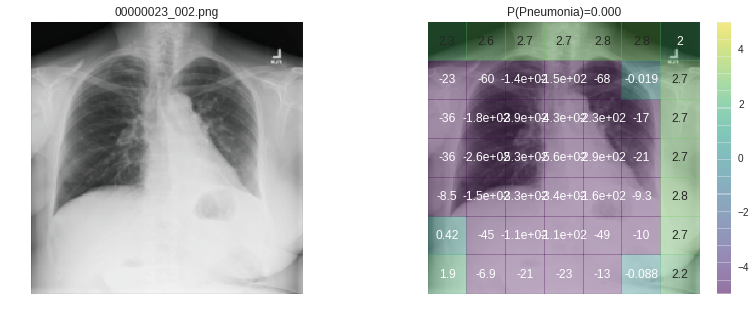

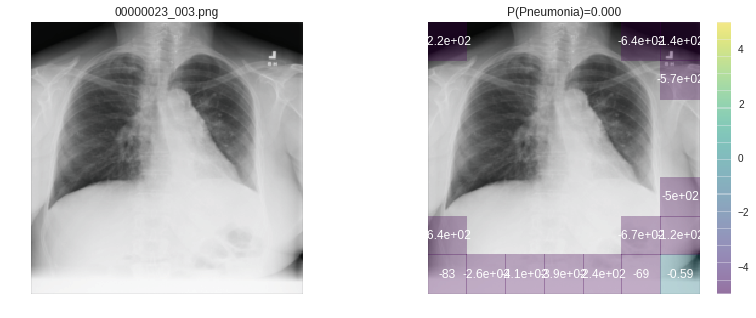

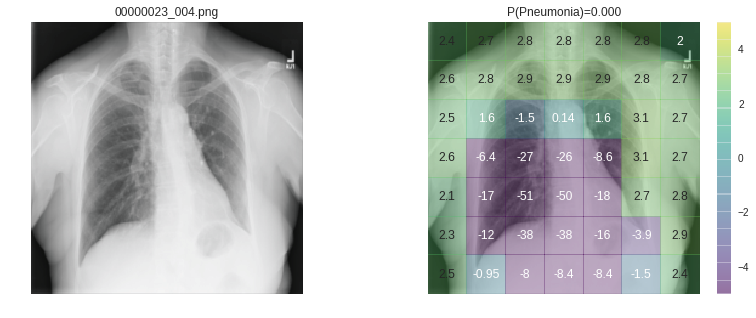

All examples exhausted - rerun cells above to generate new examples to review
All examples exhausted - rerun cells above to generate new examples to review


In [50]:
for i in range(len(dataloader)):
  preds=show_next(dataloader,model, LABEL)
  preds


In [0]:
from google.colab import files
files.download('results/aucs.csv')

In [0]:
from google.colab import files
files.download('results/preds.csv')

In [0]:
from google.colab import files
files.download('results/checkpoint')

In [0]:
from google.colab import files
files.download('results/log_train')